<a href="https://google.com" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a>

# **Signal Processing Session : Command Recognition**


**Instructor :** Tirtadwipa M

This guide will teach you how to create a simple speech recognition network that recognizes 10 different words. It is crucial to know that real speech and voice recognition systems are far more complex, but like MNIST for images, it should give you a basic understanding of the method involved. If you've done this guide, you'll have a model that attempts to label a second audio clip as "down" "go" "left" "no" "right" "stop" "up" and "yes"


## **Modules and dependencies setup**

Import required libraries and dependencies.

In [ ]:
import os
import random
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

%load_ext tensorboard
%matplotlib inline

## **Dataset preparation**

You are going to write a script to retrieve a part of the dataset of the Speech Commands. The initial data collection consists of more than 105,000 WAV audio files of people speaking thirty different words. This data has been compiled by Google and published under a CC BY licence, and you can help develop it by adding your own voice for five minutes. 

You can use a subset of the dataset to save time for data loading. Extract the mini speech commands.zip and load it with the tf.data API.


In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


In [ ]:
%ls data

ls: cannot access 'data': No such file or directory


Check all the commands of the dataset. 

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'down' 'no' 'yes' 'right' 'left' 'stop' 'go']


Extract the audio files into an array and randomize it.


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/f2b8fc18_nohash_1.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


The audio file would initially be read as a binary file that you want convert them into a numeric tensor. 

You can use tf.audio.decode wav to load an audio file, which returns the WAV-encoded audio to the Tensor and the sample rate. 

The WAV file includes time-series data with a fixed number of samples per second. Every sample reflects the amplitude of the audio signal at that specific time. In a 16-bit system, the values in mini speech commands range from-32768 to 32767. The sampling rate of this dataset is 16kHz. Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is it's parent directory.

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

Let's describe a function that uses the filename of the WAV file and outputs a tuple containing audio and labels for supervised training.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now use process path to create your training set to remove the audio-label pairs and review the results. You will create a validation and test collection using a related technique later.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

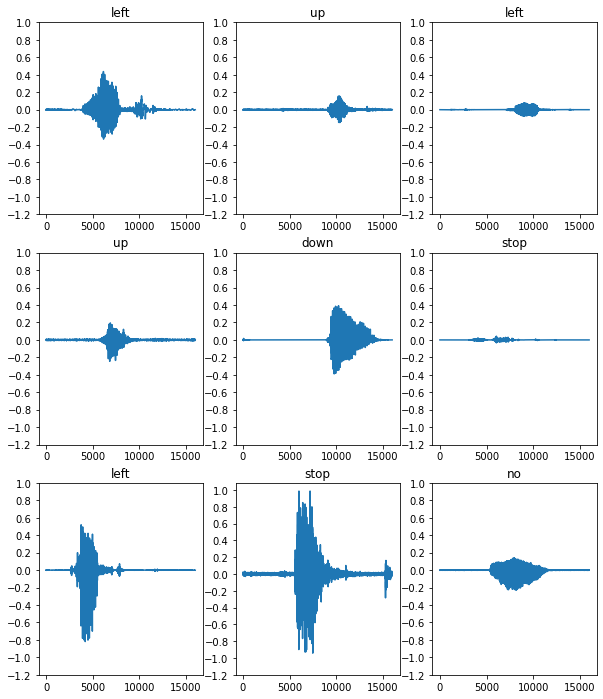

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. The STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying tf.abs on the output of `tf.signal.stft`.

Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to this video on audio signal processing.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


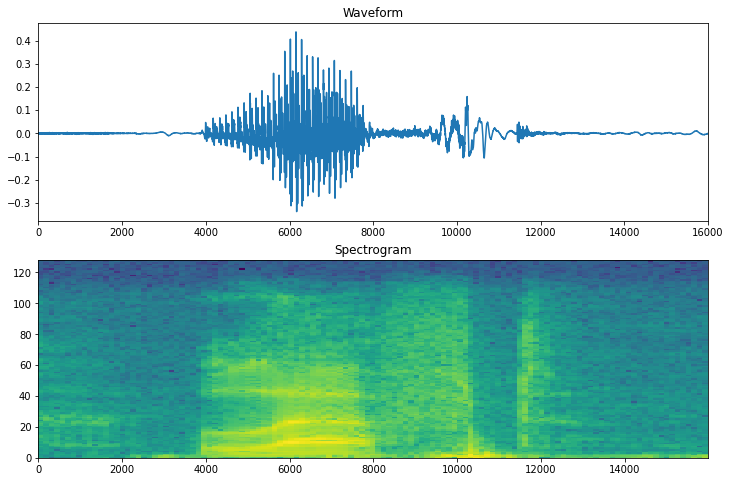

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

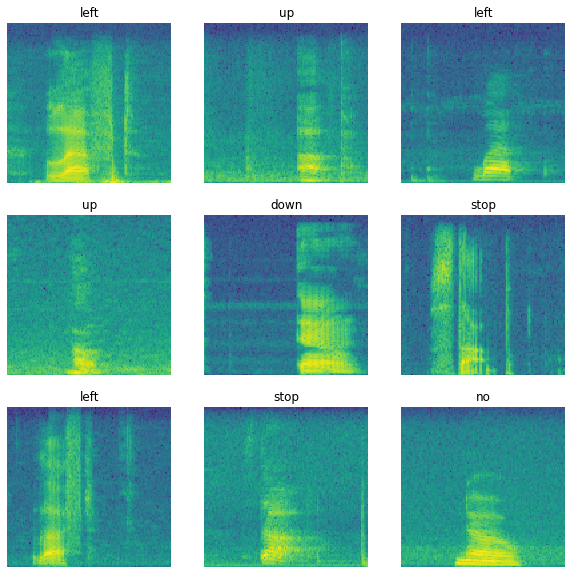

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## **Building the model**

You can develop and practice your model now. But before you do so, you would need to replicate the pre-processing training set for the validation and test sets.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset cache() and prefetch() operations to reduce read latency while training the model.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images. The model also has the following additional preprocessing layers:

* A Resizing layer to downsample the input to enable the model to train faster.
* A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).


In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## **Training the model**

Let's train the model and check the testing and validation failure curves to see how the model has progressed through training.

In [ ]:
EPOCHS = 5
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/5
100/100 [==============================] - 20s 196ms/step - loss: 0.7436 - accuracy: 0.7350 - val_loss: 0.6958 - val_accuracy: 0.7650
Epoch 2/5
100/100 [==============================] - 19s 195ms/step - loss: 0.6302 - accuracy: 0.7748 - val_loss: 0.6603 - val_accuracy: 0.7750
Epoch 3/5
100/100 [==============================] - 19s 191ms/step - loss: 0.5692 - accuracy: 0.7947 - val_loss: 0.5796 - val_accuracy: 0.8012
Epoch 4/5
100/100 [==============================] - 19s 192ms/step - loss: 0.5059 - accuracy: 0.8194 - val_loss: 0.5931 - val_accuracy: 0.8050
Epoch 5/5
100/100 [==============================] - 19s 190ms/step - loss: 0.4527 - accuracy: 0.8427 - val_loss: 0.5752 - val_accuracy: 0.8087


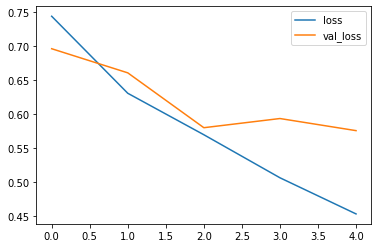

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## **Performance evaluation**

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## **Model inference**

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

In [ ]:
all_data = []
for directory in [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,d))]:
  all_data.extend([os.path.join(data_dir,directory,wavfile) for wavfile in os.listdir(os.path.join(data_dir,directory)) if wavfile.endswith('.wav')])

In [ ]:
sample_file = random.choice(all_data)

sample_ds = preprocess_dataset([str(sample_file)])

print(sample_file)
display.Audio(sample_file)

In [ ]:
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()